## Setup

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 2.5 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.3 MB/s eta 0:00:0000:0100:01


In [25]:
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt


In [26]:

df = pd.read_parquet("../../data/georgia_data/georgia_complete_dataset.parquet")
df.head()

,time,icao24,callsign,latitude,longitude,altitude,velocity,heading,vertrate,onground
0,2025-01-14 09:52:25+00:00,a4080c,UPS1302,33.821091,-84.241931,1874.52,146.111153,162.585803,-12.02944,False
1,2025-01-14 09:52:26+00:00,a4080c,UPS1302,33.820496,-84.241707,1874.52,145.958017,162.778493,-12.02944,False
2,2025-01-14 09:52:27+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False
3,2025-01-14 09:52:28+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False
4,2025-01-14 09:52:29+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474978 entries, 0 to 9474977
Data columns (total 10 columns):
 #   Column     Dtype                         
---  ------     -----                         
 0   time       timestamp[ns, tz=UTC][pyarrow]
 1   icao24     string                        
 2   callsign   string                        
 3   latitude   double[pyarrow]               
 4   longitude  double[pyarrow]               
 5   altitude   double[pyarrow]               
 6   velocity   double[pyarrow]               
 7   heading    double[pyarrow]               
 8   vertrate   double[pyarrow]               
 9   onground   bool[pyarrow]                 
dtypes: bool[pyarrow](1), double[pyarrow](6), string(2), timestamp[ns, tz=UTC][pyarrow](1)
memory usage: 771.1 MB


In [29]:
print(f"The number of unique aircraft: {df.icao24.nunique()}")

# Get unique combinations of icao24 and callsign
unique_aircraft = df[['icao24', 'callsign']].drop_duplicates()
print("\nUnique aircraft identifiers (icao24 and callsign combinations):")
print(unique_aircraft)

The number of unique aircraft: 3262

Unique aircraft identifiers (icao24 and callsign combinations):
         icao24 callsign
0        a4080c  UPS1302
455      a935e7   N693AM
545      a8e1f6     <NA>
1784     a84343  UPS1326
3455     ace96a   ASA520
...         ...      ...
9465137  ab48cc  SCX8216
9466683  ac77d0   NKS789
9468774  aaf804  SCX3043
9469971  a6d326     <NA>
9469972  a6d326   N539PE

[5360 rows x 2 columns]


In [12]:
# find the time bounds of the data
time_min = df.time.min()
time_max = df.time.max()
time_range = time_max - time_min

print(f"The time bounds of the data: {time_min} to {time_max}")
print(f"Time range: {time_range}")


The time bounds of the data: 2025-01-14 09:52:25+00:00 to 2025-01-14 20:59:59+00:00
Time range: 0 days 11:07:34


## Univariate Analysis 

Exploring the numerical features - altitude, speed, vertical rate, etc.

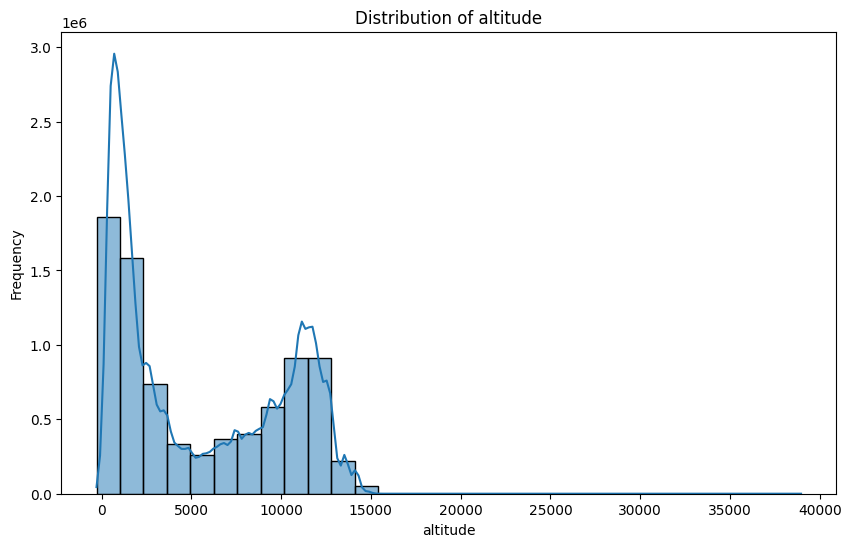

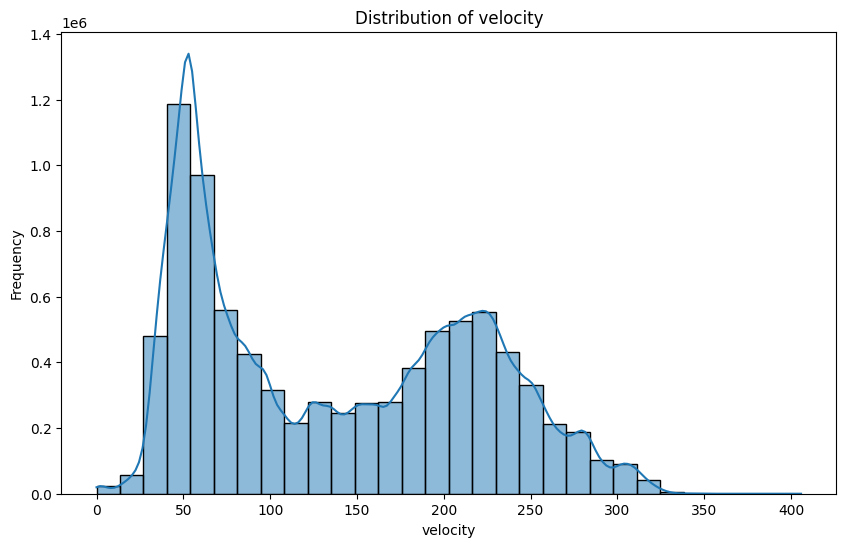

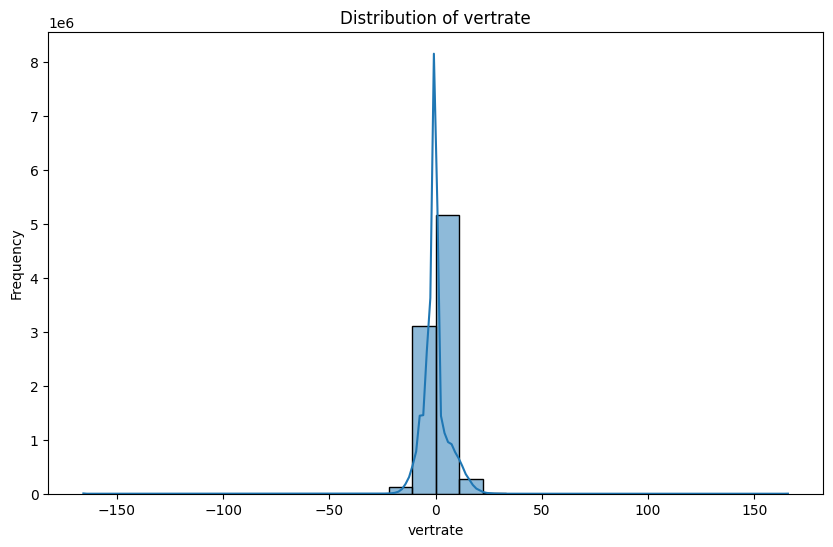

In [13]:
# Plotting histograms for each numerical feature
numerical_features = ['altitude', 'velocity', 'vertrate']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Minimum altitude value: -281.94


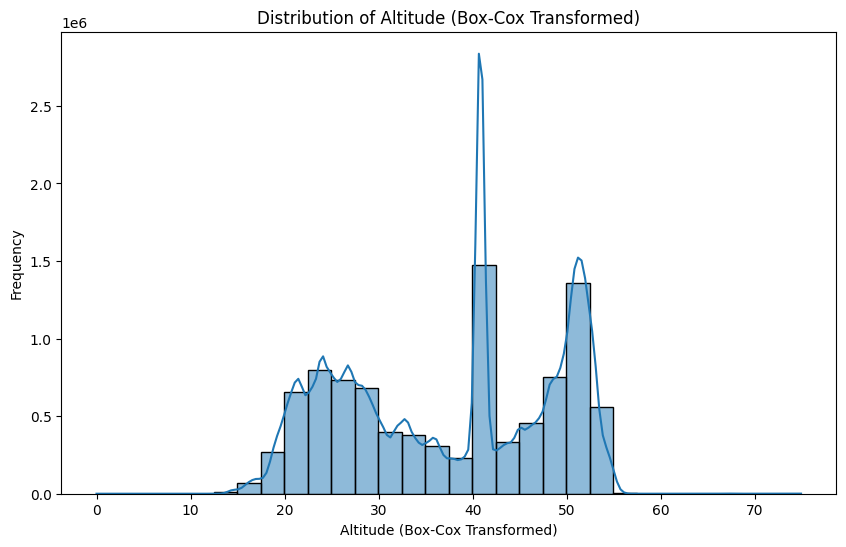

Box-Cox transformation lambda parameter: 0.2976239545529159


In [19]:
import scipy.stats as stats

# First handle missing values
altitude_clean = df['altitude'].fillna(df['altitude'].mean())

# Check minimum altitude value
min_alt = altitude_clean.min()
print(f"Minimum altitude value: {min_alt}")

# Add a constant to make all values positive
constant = abs(min_alt) + 1 if min_alt <= 0 else 0
altitude_shifted = altitude_clean + constant

# Now apply boxcox to shifted altitude
df['altitude_boxcox'], lambda_param = stats.boxcox(altitude_shifted)

# visualize
plt.figure(figsize=(10, 6))
sns.histplot(df['altitude_boxcox'], bins=30, kde=True)
plt.title('Distribution of Altitude (Box-Cox Transformed)')
plt.xlabel('Altitude (Box-Cox Transformed)')
plt.ylabel('Frequency')
plt.show()

print(f"Box-Cox transformation lambda parameter: {lambda_param}")

## Visualizing Flight Paths

Tracking a single aircraft - simple method using matplotlib

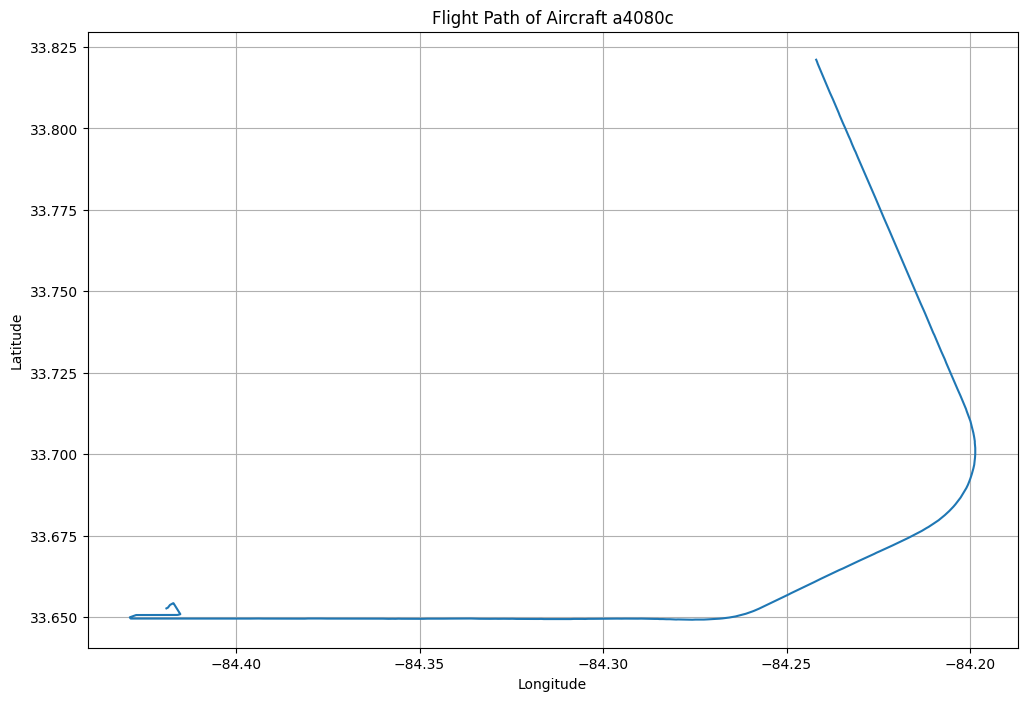

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import folium  # for interactive map visualization

# Filter for a single aircraft
icao24_to_track = 'a4080c'  # This is the aircraft ID from your data
single_aircraft = df[df['icao24'] == icao24_to_track].copy()

# Sort by time to ensure proper trajectory plotting
single_aircraft = single_aircraft.sort_values('time')

# Method 1: Simple Matplotlib plot
plt.figure(figsize=(12, 8))
plt.plot(single_aircraft['longitude'], single_aircraft['latitude'])
plt.title(f'Flight Path of Aircraft {icao24_to_track}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


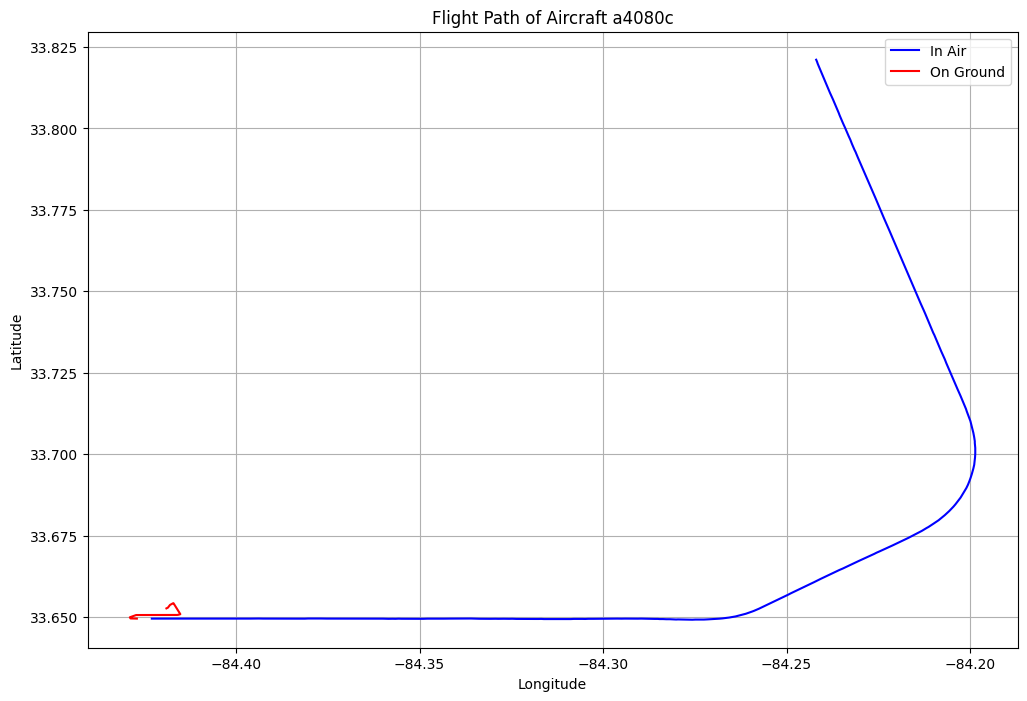

In [24]:
# Method 1: Simple Matplotlib plot
plt.figure(figsize=(12, 8))

# Split the data into segments based on 'onground' status
for onground_status in [False, True]:
    mask = single_aircraft['onground'] == onground_status
    segment = single_aircraft[mask]
    
    plt.plot(segment['longitude'], segment['latitude'],
            label=f"{'On Ground' if onground_status else 'In Air'}",
            color='red' if onground_status else 'blue')

plt.title(f'Flight Path of Aircraft {icao24_to_track}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

Interactive map using Folium

In [16]:

# Method 2: Interactive Map with Folium
m = folium.Map(
    location=[single_aircraft['latitude'].mean(), 
              single_aircraft['longitude'].mean()],
    zoom_start=6
)

# Add the flight path
points = list(zip(single_aircraft['latitude'], 
                 single_aircraft['longitude']))
folium.PolyLine(
    points,
    weight=2,
    color='red',
    opacity=0.8
).add_to(m)

# Add markers for start and end points
folium.Marker(
    points[0],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    points[-1],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# Display the map
m

## Unsupervised Learning 

- Clustering

In [8]:
# First, let's create a function to calculate flight characteristics
import numpy as np
from scipy.stats import circmean
from math import atan2, degrees
from sklearn.preprocessing import StandardScaler

def calculate_trajectory_features(trajectory_df):
    """
    Calculate features for a single aircraft trajectory
    """
    # Sort by time to ensure proper calculations
    trajectory_df = trajectory_df.sort_values('time')
    
    # Basic statistical features
    features = {
        'avg_altitude': trajectory_df['altitude'].mean(),
        'alt_std': trajectory_df['altitude'].std(),
        'avg_velocity': trajectory_df['velocity'].mean(),
        'vel_std': trajectory_df['velocity'].std(),
        'flight_duration': (trajectory_df['time'].max() - trajectory_df['time'].min()).total_seconds(),
        'path_length': len(trajectory_df)
    }
    
    # Calculate heading changes
    lat_rad = np.radians(trajectory_df['latitude'])
    lon_rad = np.radians(trajectory_df['longitude'])
    
    # Calculate heading for each consecutive point
    headings = []
    for i in range(len(trajectory_df)-1):
        dy = lat_rad.iloc[i+1] - lat_rad.iloc[i]
        dx = lon_rad.iloc[i+1] - lon_rad.iloc[i]
        heading = degrees(atan2(dy, dx)) % 360
        headings.append(heading)
    
    if headings:
        features['avg_heading'] = np.mean(headings)
        features['heading_changes'] = np.std(headings)
    
    return features

# Create feature matrix for all aircraft
def create_feature_matrix(df):
    all_features = []
    
    # Group by aircraft
    for icao24, trajectory in df.groupby('icao24'):
        features = calculate_trajectory_features(trajectory)
        features['icao24'] = icao24
        all_features.append(features)
    
    return pd.DataFrame(all_features)

# Create the feature matrix
feature_matrix = create_feature_matrix(df)

# Handle missing values before scaling
# Option 1: Remove rows with any missing values
feature_matrix = feature_matrix.dropna()

# OR Option 2: Fill missing values with mean/median
# feature_matrix = feature_matrix.fillna(feature_matrix.mean())

# Select numerical columns for clustering
numeric_columns = ['avg_altitude', 'alt_std', 'avg_velocity', 'vel_std', 
                  'flight_duration', 'path_length', 'avg_heading', 'heading_changes']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix[numeric_columns])



Cluster sizes:
cluster
0    1293
4     784
3     598
1     313
2     253
Name: count, dtype: int64


In [35]:

# Perform K-means clustering
from sklearn.cluster import KMeans

n_clusters = 4  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_matrix['cluster'] = kmeans.fit_predict(scaled_features)

# Display results
print("\nCluster sizes:")
print(feature_matrix['cluster'].value_counts())



Cluster sizes:
cluster
0    1295
2     901
3     667
1     378
Name: count, dtype: int64


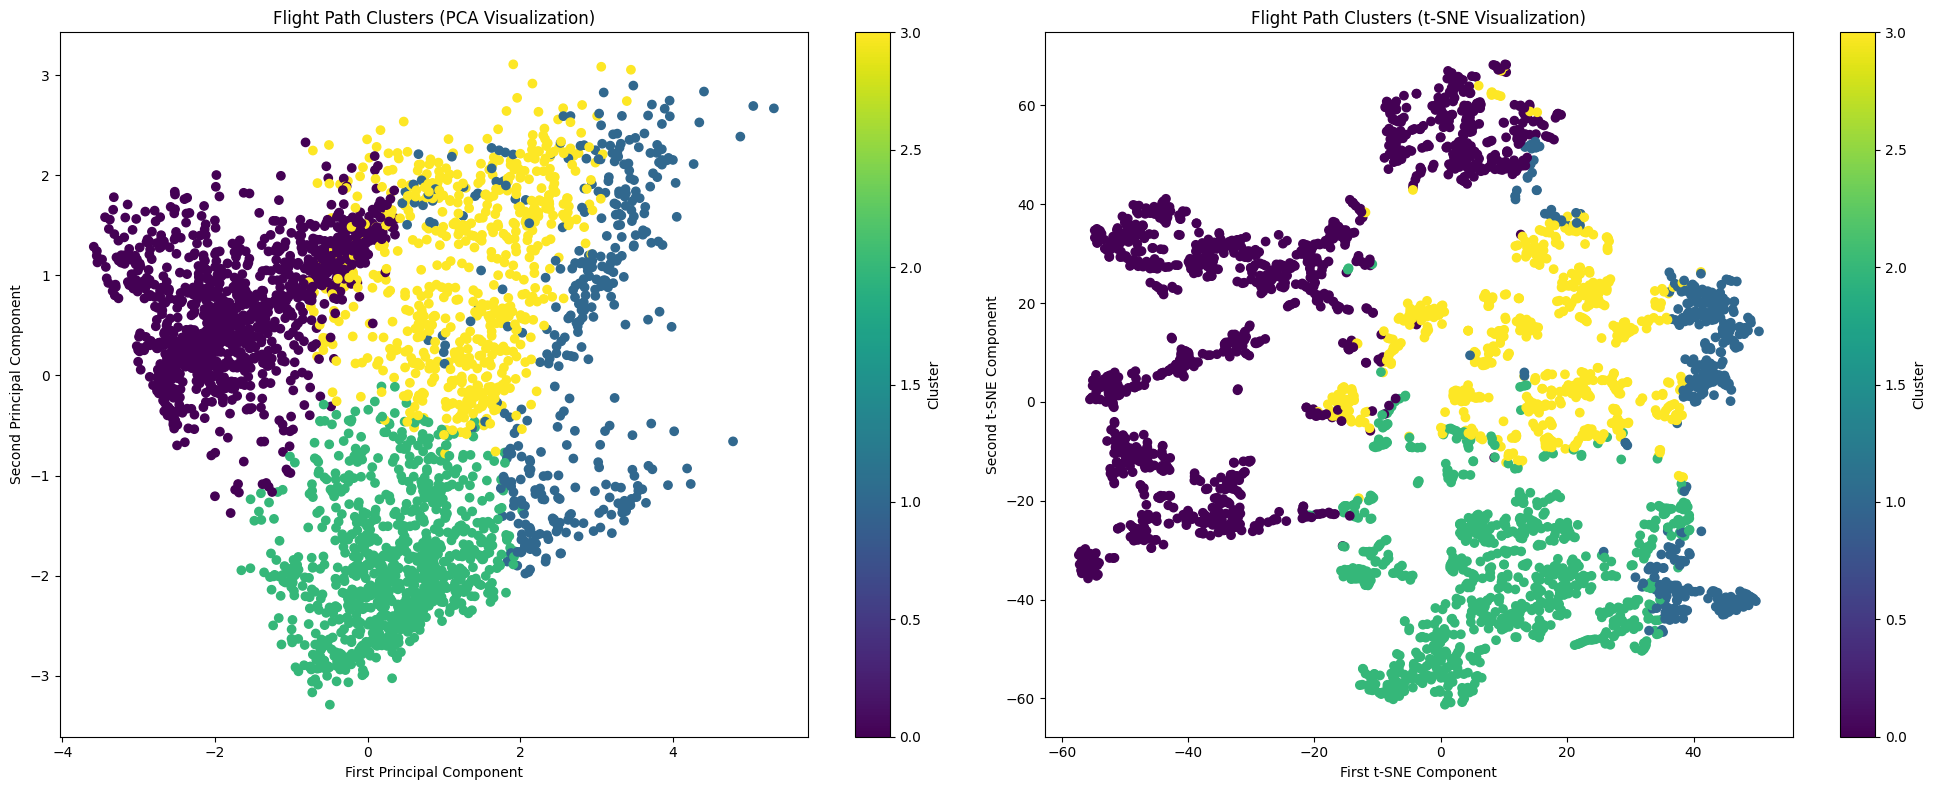

In [36]:
# Visualize clusters using both PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))

# PCA Plot
plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
scatter_pca = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                         c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (PCA Visualization)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter_pca, label='Cluster')

# t-SNE Plot
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_features)
scatter_tsne = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                          c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (t-SNE Visualization)')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.colorbar(scatter_tsne, label='Cluster')

plt.tight_layout()
plt.show()

In [37]:
# Analyze cluster characteristics
cluster_stats = feature_matrix.groupby('cluster')[numeric_columns].mean()
print("\nCluster characteristics:")
print(cluster_stats)


Cluster characteristics:
         avg_altitude      alt_std avg_velocity    vel_std  flight_duration  \
cluster                                                                       
0        11033.555572   465.225411   227.594279  11.658941      4971.718919   
1         3835.328408  1805.616445   118.810775  41.061775     24737.256614   
2         1573.552038   410.417908    77.507851  11.249897      4809.410655   
3         5574.981102  2912.994194   164.552472   52.91271      8715.004498   

         path_length  avg_heading  heading_changes  
cluster                                             
0        1673.904247   172.087653        52.939006  
1        8363.489418   111.221535       108.260643  
2        2246.807991    84.728632        86.653115  
3        3131.778111   126.429218       100.002441  


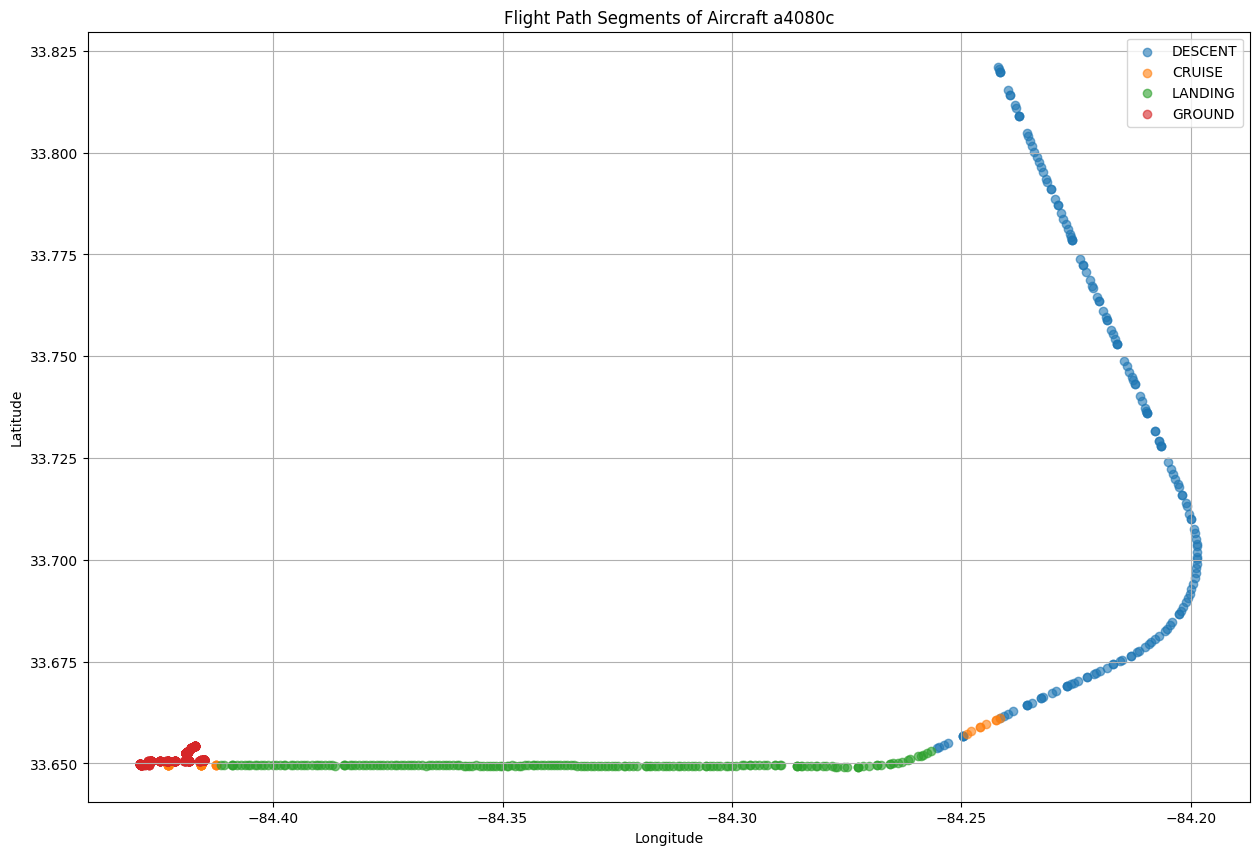

In [30]:
# First, let's create a function to identify flight phases
def identify_flight_phase(row, prev_row=None):
    """
    Identify flight phase based on current and previous state
    
    Flight phases:
    - GROUND: Aircraft is on ground
    - TAKEOFF: Initial climb from ground
    - CLIMB: Climbing to cruise altitude
    - CRUISE: Level flight at high altitude
    - DESCENT: Decreasing altitude
    - LANDING: Final approach to ground
    """
    
    # Constants for classification
    CLIMB_THRESHOLD = 2.0  # m/s vertical rate
    DESCENT_THRESHOLD = -2.0  # m/s vertical rate
    GROUND_ALTITUDE_THRESHOLD = 50  # meters
    
    # If aircraft is on ground
    if row['onground'] or row['altitude'] < GROUND_ALTITUDE_THRESHOLD:
        return 'GROUND'
    
    # If no previous row, can only use current row information
    if prev_row is None:
        if row['vertrate'] > CLIMB_THRESHOLD:
            return 'CLIMB'
        elif row['vertrate'] < DESCENT_THRESHOLD:
            return 'DESCENT'
        else:
            return 'CRUISE'
    
    # Using both current and previous state
    if row['vertrate'] > CLIMB_THRESHOLD:
        if prev_row['onground'] or prev_row['altitude'] < GROUND_ALTITUDE_THRESHOLD:
            return 'TAKEOFF'
        return 'CLIMB'
    
    elif row['vertrate'] < DESCENT_THRESHOLD:
        if row['altitude'] < 1000:  # Below 1000m and descending
            return 'LANDING'
        return 'DESCENT'
    
    return 'CRUISE'

# Apply the phase identification to a single aircraft trajectory
def segment_trajectory(aircraft_df):
    """
    Segment a single aircraft's trajectory into flight phases
    """
    # Sort by time to ensure proper sequence
    aircraft_df = aircraft_df.sort_values('time').copy()
    
    # Initialize phases list
    phases = []
    prev_row = None
    
    # Identify phase for each point
    for _, row in aircraft_df.iterrows():
        phase = identify_flight_phase(row, prev_row)
        phases.append(phase)
        prev_row = row
    
    aircraft_df['flight_phase'] = phases
    return aircraft_df

# Let's apply this to your single aircraft example
icao24_to_track = 'a4080c'
single_aircraft = df[df['icao24'] == icao24_to_track].copy()
segmented_trajectory = segment_trajectory(single_aircraft)

# Visualize the segmented trajectory
plt.figure(figsize=(15, 10))

# Create a scatter plot colored by flight phase
for phase in segmented_trajectory['flight_phase'].unique():
    mask = segmented_trajectory['flight_phase'] == phase
    segment = segmented_trajectory[mask]
    plt.scatter(segment['longitude'], segment['latitude'], 
               label=phase, alpha=0.6)

plt.title(f'Flight Path Segments of Aircraft {icao24_to_track}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()


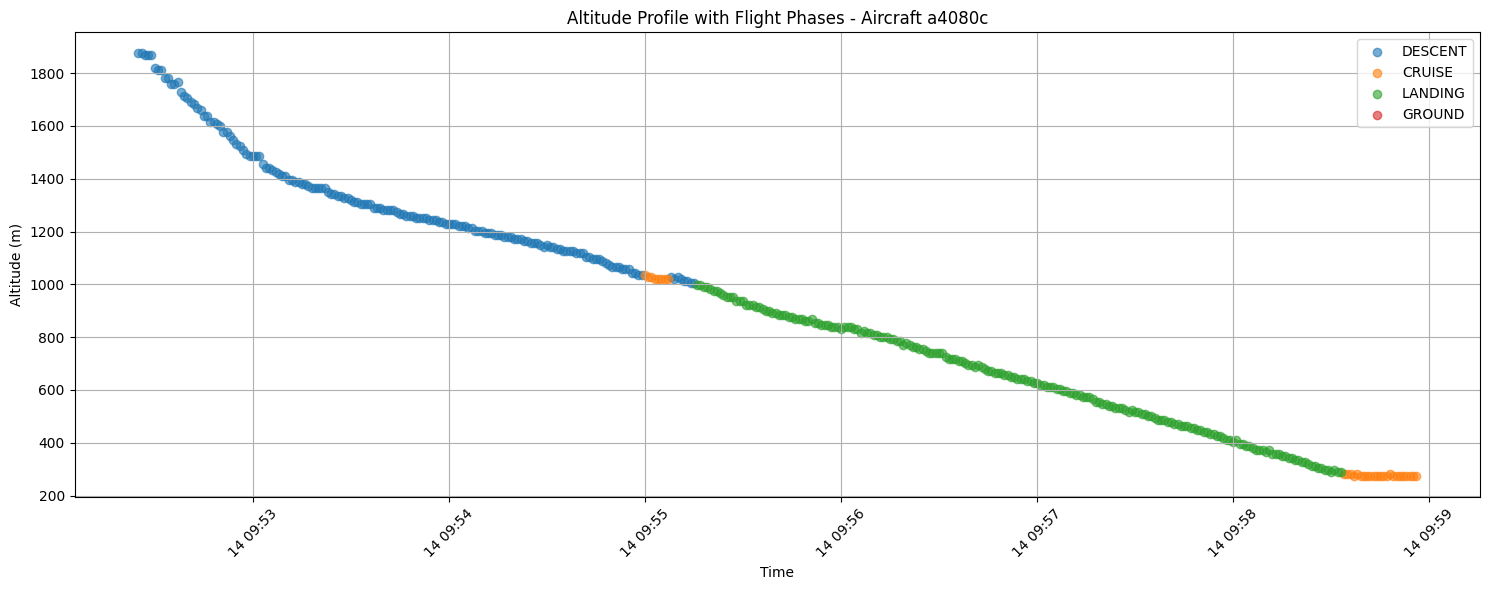


Flight phase statistics:
             altitude         velocity        vertrate        time
                 mean     std     mean    std     mean   std count
flight_phase                                                      
CRUISE         469.24  333.14    73.92  16.99     -0.8  0.74    31
DESCENT       1322.75  226.76   129.99  17.48    -5.45  3.49   163
GROUND           <NA>    <NA>     57.1    0.0      0.0   0.0   645
LANDING         641.0  203.76    73.73   7.07     -3.8  0.58   198


In [31]:

# Plot altitude profile with phases
plt.figure(figsize=(15, 6))
for phase in segmented_trajectory['flight_phase'].unique():
    mask = segmented_trajectory['flight_phase'] == phase
    segment = segmented_trajectory[mask]
    plt.scatter(segment['time'], segment['altitude'], 
               label=phase, alpha=0.6)

plt.title(f'Altitude Profile with Flight Phases - Aircraft {icao24_to_track}')
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print phase statistics
print("\nFlight phase statistics:")
phase_stats = segmented_trajectory.groupby('flight_phase').agg({
    'altitude': ['mean', 'std'],
    'velocity': ['mean', 'std'],
    'vertrate': ['mean', 'std'],
    'time': 'count'
}).round(2)
print(phase_stats)

In [33]:
# First, let's create a function to calculate flight characteristics
import numpy as np
from scipy.stats import circmean
from math import atan2, degrees
from sklearn.preprocessing import StandardScaler

def calculate_trajectory_features(trajectory_df):
    """
    Calculate features for a single aircraft trajectory
    """
    # Sort by time to ensure proper calculations
    trajectory_df = trajectory_df.sort_values('time')
    
    # Basic statistical features
    features = {
        'avg_altitude': trajectory_df['altitude'].mean(),
        'alt_std': trajectory_df['altitude'].std(),
        'avg_velocity': trajectory_df['velocity'].mean(),
        'vel_std': trajectory_df['velocity'].std(),
        'flight_duration': (trajectory_df['time'].max() - trajectory_df['time'].min()).total_seconds(),
        'path_length': len(trajectory_df)
    }
    
    # Calculate heading changes
    lat_rad = np.radians(trajectory_df['latitude'])
    lon_rad = np.radians(trajectory_df['longitude'])
    
    # Calculate heading for each consecutive point
    headings = []
    for i in range(len(trajectory_df)-1):
        dy = lat_rad.iloc[i+1] - lat_rad.iloc[i]
        dx = lon_rad.iloc[i+1] - lon_rad.iloc[i]
        heading = degrees(atan2(dy, dx)) % 360
        headings.append(heading)
    
    if headings:
        features['avg_heading'] = np.mean(headings)
        features['heading_changes'] = np.std(headings)
    
    return features

# Create feature matrix for all aircraft
def create_feature_matrix(df):
    all_features = []
    
    # Group by aircraft
    for icao24, trajectory in df.groupby('icao24'):
        features = calculate_trajectory_features(trajectory)
        features['icao24'] = icao24
        all_features.append(features)
    
    return pd.DataFrame(all_features)

# Create the feature matrix
feature_matrix = create_feature_matrix(df)

# Handle missing values before scaling
feature_matrix = feature_matrix.dropna()

# Select numerical columns for clustering
numeric_columns = ['avg_altitude', 'alt_std', 'avg_velocity', 'vel_std', 
                  'flight_duration', 'path_length', 'avg_heading', 'heading_changes']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix[numeric_columns])

# Perform K-means clustering
from sklearn.cluster import KMeans

n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_matrix['cluster'] = kmeans.fit_predict(scaled_features)

# Display results
print("\nCluster sizes:")
print(feature_matrix['cluster'].value_counts())



Cluster sizes:
cluster
0    1293
4     784
3     598
1     313
2     253
Name: count, dtype: int64


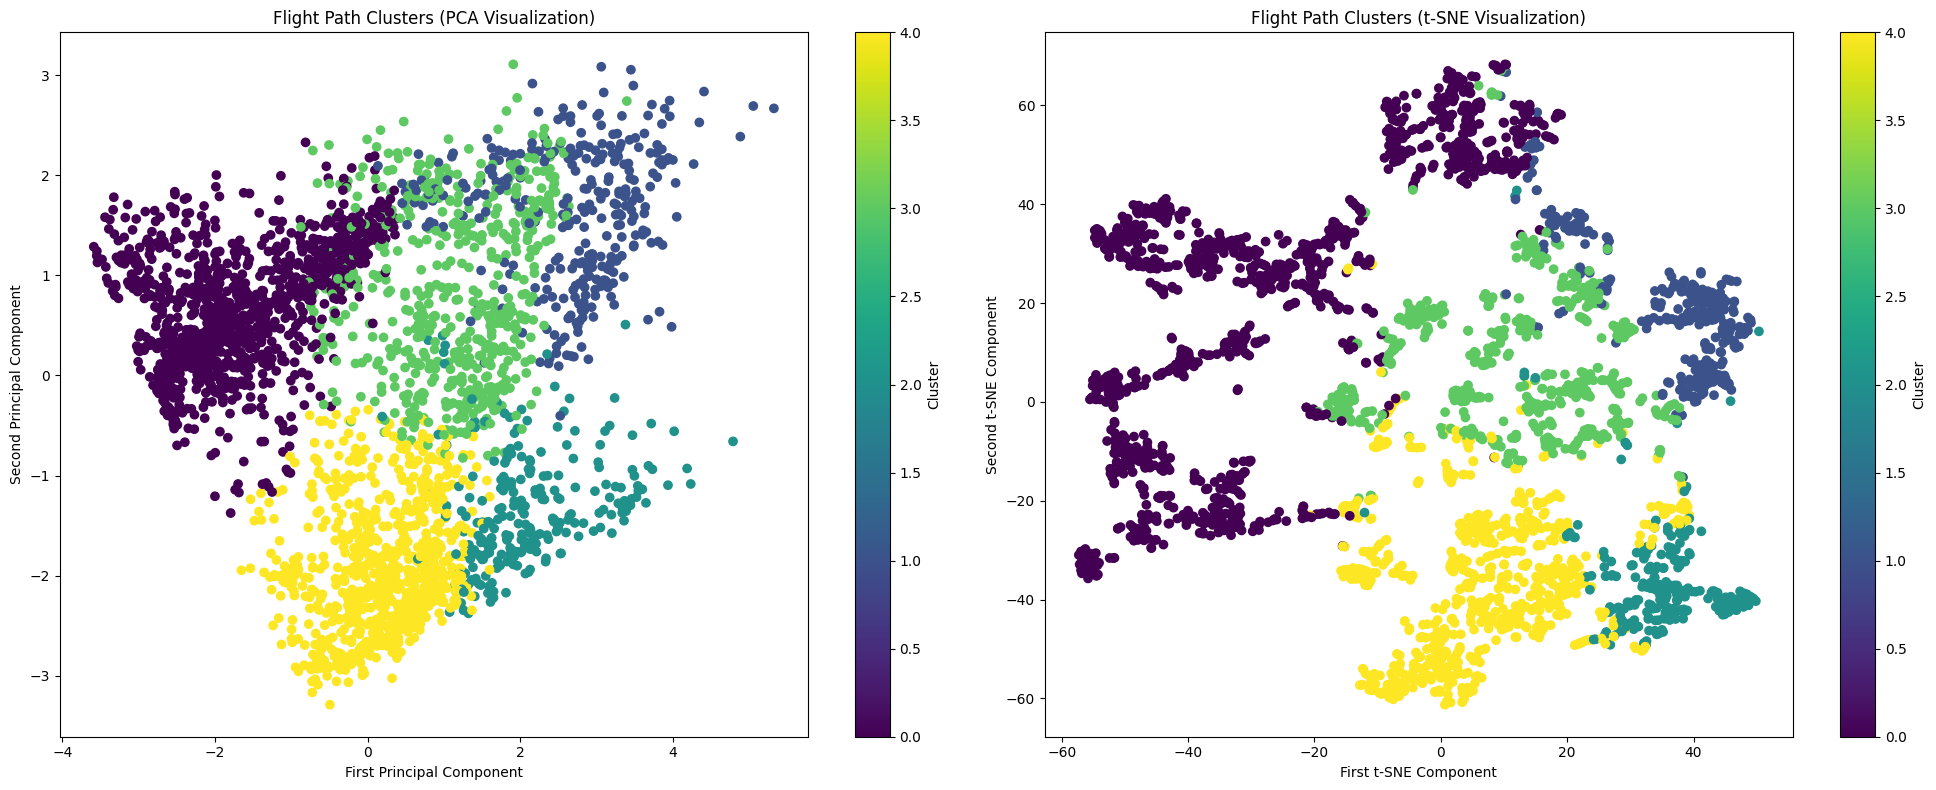


Cluster characteristics:
         avg_altitude      alt_std avg_velocity    vel_std  flight_duration  \
cluster                                                                       
0        11040.351048   462.230913   227.588933  11.629623      4996.423047   
1         5763.686129  2791.315493   163.433785  60.323287     25392.354633   
2         1416.862783   551.704328    61.962618  12.760358     18197.624506   
3         5349.777815  2832.048674   161.072609  50.746955      6645.704013   
4         1578.635594   374.044598    78.840446  10.912339      3761.395408   

         path_length  avg_heading  heading_changes  
cluster                                             
0        1677.222738   172.348605        52.997089  
1        6636.274760   119.644203       106.386019  
2        8124.470356    96.937814       106.175467  
3        2890.476589   125.840919        99.431825  
4        1801.755102    83.533824        84.321346  


In [34]:

# Visualize clusters using both PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))

# PCA Plot
plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
scatter_pca = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                         c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (PCA Visualization)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter_pca, label='Cluster')

# t-SNE Plot
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_features)
scatter_tsne = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                          c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (t-SNE Visualization)')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.colorbar(scatter_tsne, label='Cluster')

plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_stats = feature_matrix.groupby('cluster')[numeric_columns].mean()
print("\nCluster characteristics:")
print(cluster_stats)


Aircraft a4080c belongs to cluster 2


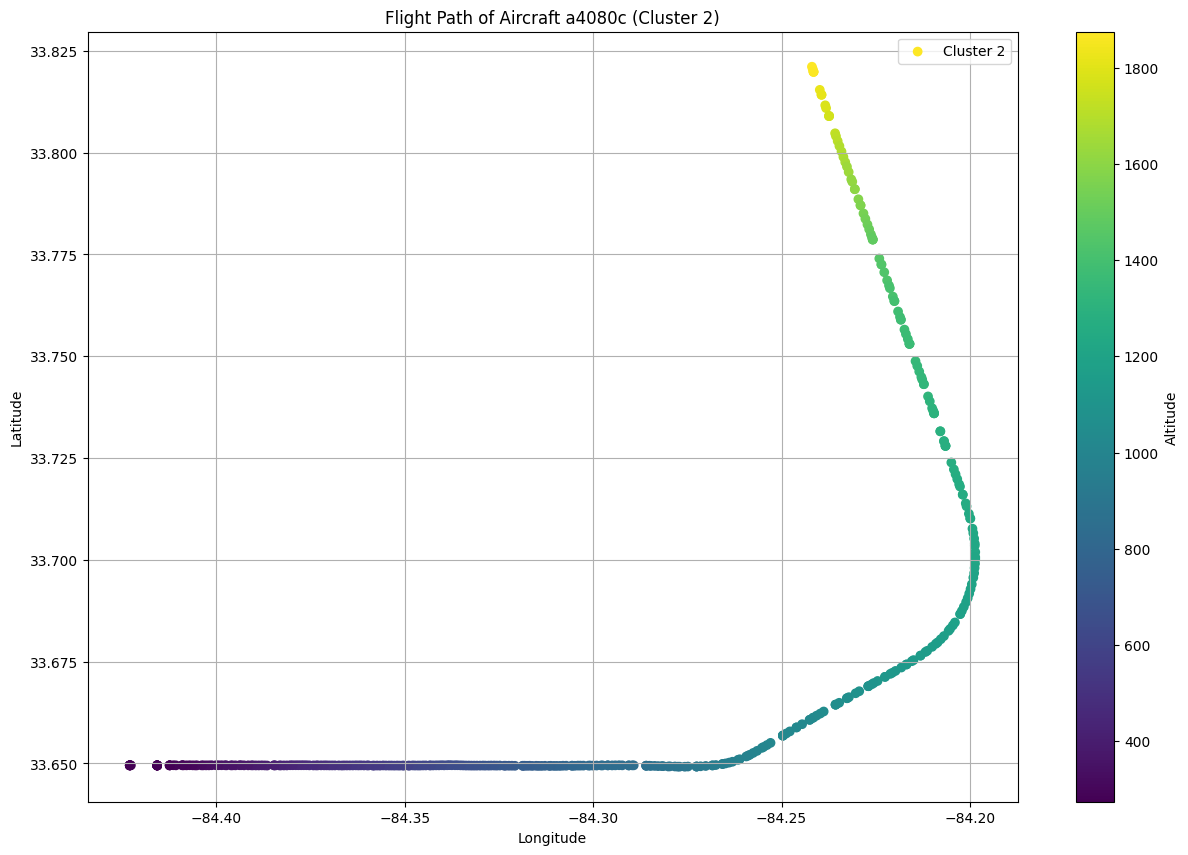


Cluster characteristics:
avg_altitude       1573.552038
alt_std             410.417908
avg_velocity         77.507851
vel_std              11.249897
flight_duration    4809.410655
path_length        2246.807991
avg_heading          84.728632
heading_changes      86.653115
Name: 2, dtype: object


In [38]:
def label_flight_path(trajectory_df, kmeans_model, scaler, numeric_columns):
    """
    Label a single flight path with cluster assignments
    """
    # Calculate features for the trajectory
    features = calculate_trajectory_features(trajectory_df)
    
    # Convert to DataFrame with same structure as training data
    features_df = pd.DataFrame([features])
    
    # Select and scale the numeric columns
    features_scaled = scaler.transform(features_df[numeric_columns])
    
    # Predict cluster
    cluster = kmeans_model.predict(features_scaled)[0]
    
    return cluster

# Let's apply this to your single aircraft example
icao24_to_track = 'a4080c'
single_aircraft = df[df['icao24'] == icao24_to_track].copy()

# Get the cluster label
cluster_label = label_flight_path(single_aircraft, kmeans, scaler, numeric_columns)
print(f"\nAircraft {icao24_to_track} belongs to cluster {cluster_label}")

# Let's visualize this flight with its cluster characteristics
plt.figure(figsize=(15, 10))

# Plot the trajectory
plt.scatter(single_aircraft['longitude'], single_aircraft['latitude'], 
           c=single_aircraft['altitude'], cmap='viridis',
           label=f'Cluster {cluster_label}')

plt.colorbar(label='Altitude')
plt.title(f'Flight Path of Aircraft {icao24_to_track} (Cluster {cluster_label})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

# Print the characteristics of this cluster
print("\nCluster characteristics:")
print(cluster_stats.loc[cluster_label])